In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import healpy as hp
import pymaster as nmt
from weak_lensing import *
c = cosmology()


In [2]:
# l bins are integers but close to the fiducial values
lmin = 8
lmax = 2048
n_bins = 32

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ells_binned = b.get_effective_ells()

print(ells_binned)

[  12.    23.    37.5   55.5   77.   102.   131.   163.   198.5  238.
  280.5  326.5  376.5  430.   486.5  546.5  610.5  678.   748.5  822.5
  900.5  982.  1066.5 1155.  1247.  1342.  1441.  1543.5 1649.5 1759.
 1872.  1989. ]


In [3]:
data = np.load('Cls_halo.npz')
cls_ge = data['cls_gk']
cls_ia = data['cls_gI']
cls_ia_mag = data['cls_mag_I']
cls_mag = data['cls_mag_k']
cls_gg = data['cls_gg']
cls_ee = data['cls_kk']
ells_data = data['ells']

cls_total_binned = np.zeros((5, 4, len(ells_binned)))
cls_total = cls_ge+cls_ia_mag+cls_ia+cls_mag
print("Bin lmax:", b.lmax)
print("Cl length:", len(cls_total[0, 0]))

for i in range(5):
    for j in range(4):
        cls_total_binned[i, j, :] = b.bin_cell(cls_total[i, j, :] ) 

Bin lmax: 2048
Cl length: 2049


In [4]:
rows_array = np.loadtxt("pcls_ge_nside1024.csv", delimiter=",")
pcls = np.zeros((5, 4, 2, len(ells_binned)))
for row in rows_array:
    i, j, s = row[:3].astype(int)
    pcls[i, j, s, :] = row[3:]

print(np.shape(pcls))

(5, 4, 2, 32)


In [7]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

header_source = hdudes['nz_source'].header
header_lens = hdudes['nz_lens'].header

#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
ngal_source_dict = {}
sige_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]
    ngal_source_dict[i] = header_source['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str
    sige_source_dict[i] = header_source['SIG_E_' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
ngal_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]
    ngal_lens_dict[i] = header_lens['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str

kmax = 1 / Rlin, lmax = kmax χ(⟨zi⟩) (17)  where ⟨zi⟩ = ∫  z ni (z) dz / ∫  ni (z) dz is the mean redshift for the ith tomographic set of lenses

In [8]:
lmax_list = np.zeros(5)
R_min = 6 #Mpc/h
k_max = 1/R_min 
for i in range(5):
    nz_lens = nz_lens_dict[i]  
    z_mean = zl_means[i]
    chi_i = c.comoving_distance(z_mean)
    lmax_list[i] = int(k_max * chi_i)
    print(f"lens bin {i+1}: lmax = {lmax_list[i]}")

lens bin 1: lmax = 170.0
lens bin 2: lmax = 279.0
lens bin 3: lmax = 363.0
lens bin 4: lmax = 440.0
lens bin 5: lmax = 499.0


In [9]:
outdir="cov_workspaces_nside1024"

i = 1
j = 3
# Load workspaces
cw = nmt.NmtCovarianceWorkspace(fname=os.path.join(outdir, f"cw{i}{j}.fits"))
wa = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))
wb = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))

# For Gaussian covariance, you need 4 Cl combinations:
cl_gg = cls_gg[i-1,j-1,:] + 1.0 / ngal_lens_dict[i-1]
cl_ge = cls_total[i-1,j-1,:]
cl_gb = np.zeros(lmax+1)
cl_ee = cls_ee[i-1,j-1,:]
cl_eb = np.zeros(lmax+1)
cl_bb = np.zeros(lmax+1)

if i == j:
    cl_ee += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]
    cl_bb += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]

# Compute Gaussian covariance (bandpowers, not pseudo)
cov = nmt.gaussian_covariance(
            cw, 0, 2, 0, 2,
            [cl_gg],                  
            [cl_ge, cl_gb],          
            [cl_ge, cl_gb],        
            [cl_ee, cl_eb, cl_eb, cl_bb], 
            wa, wb
).reshape([len(ells_binned), 2, len(ells_binned), 2])

cov_ge_ge = cov[:, 0, :, 0] 

# Define data and template
y = pcls[i-1, j-1, 0, :]
m = cls_total_binned[i-1, j-1, :]

#l_cut = ells_binned <= lmax_list[i-1]
#y = y[l_cut]
#m = m[l_cut]
#cov_ge_ge = cov_ge_ge[np.ix_(l_cut, l_cut)]

# Invert covariance safely
cov_inv = np.linalg.pinv(cov_ge_ge)

# Compute C^{-1} m
Cm = cov_inv @ m

# Compute matched-filter amplitude estimator A_hat
A_hat = (Cm @ y) / (Cm @ m)

# Variance of A_hat
sigmaA2 = 1.0 / (Cm @ m)

# Matched-filter SNR
snr = A_hat / np.sqrt(sigmaA2)

res = y - A_hat * m
chi2 = res @ cov_inv @ res

norm(m) = 2.317783626443255e-06, norm(y) = 1.9042699916200751e-06
S/N =  185.69765170300178
cond(cov_ge_ge) = 52479729.635482974
Chi2 =  223.02091065991772
(y-m)/m =  0.1636475609117737


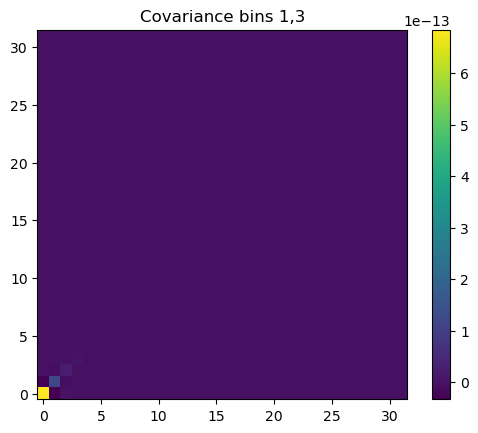

In [26]:
print(f"norm(m) = {np.linalg.norm(m)}, norm(y) = {np.linalg.norm(y)}")
print("S/N = ",snr)
print(f"cond(cov_ge_ge) = {np.linalg.cond(cov_ge_ge)}")
print('Chi2 = ',chi2)
print('(y-m)/m = ',np.mean(np.abs(y - m) / np.abs(m)))
plt.imshow(cov_ge_ge, origin='lower')
plt.colorbar()
plt.title(f"Covariance bins {i},{j}")
plt.show()

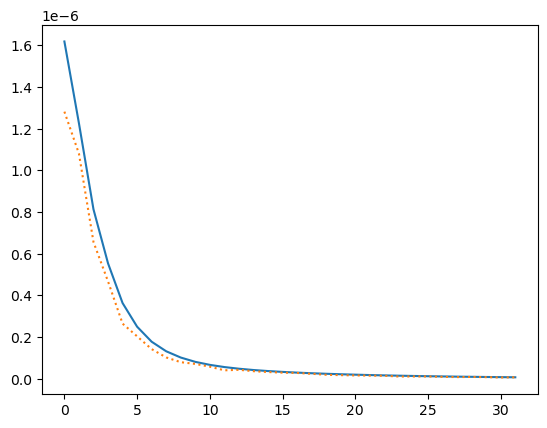

In [27]:
plt.plot(m)
plt.plot(y,':')

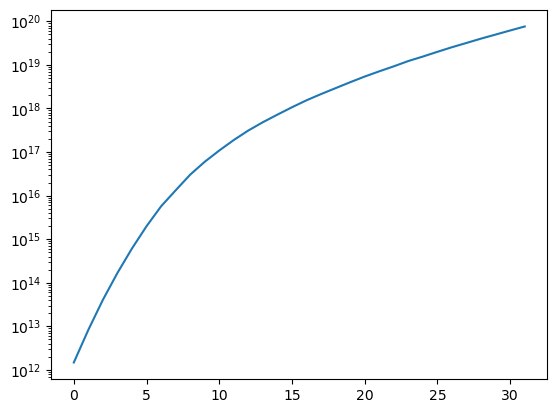

In [15]:
plt.plot(np.diag(cov_inv))
plt.yscale("log")

### Matched Filtering

We assume a data model

$$
y = A\,m + n, \qquad n \sim \mathcal{N}(0,\,C)
$$

where  
- $y$ is the data vector  
- $m$ is the known template (shape)  
- $A$ is an unknown amplitude  
- $C$ is the noise covariance  

---

### Matched-filter estimator for $A$

$$
\hat{A} = \frac{(C^{-1} m)\cdot y}{(C^{-1} m)\cdot m}
$$

---

### Variance of the estimator

$$
\sigma_A^2 = \frac{1}{(C^{-1} m)\cdot m}
$$

---

### Signal-to-noise ratio (SNR)

$$
\mathrm{SNR} = \frac{\hat{A}}{\sigma_A}
$$

If the model is correct ($y = A m$), then

$$
\mathrm{SNR} = A\, (C^{-1} m)\cdot m
$$

---

### Practical SNR from data

$$
\mathrm{SNR} = \frac{(C^{-1} m)\cdot y}{\sqrt{(C^{-1} m)\cdot m}}
$$


In [10]:
import os
outdir="cov_workspaces_nside1024"

snr_dict = {}
chi2_dict = {}

snr_cut_dict = {}
chi2_cut_dict = {}


for i in range(1, 6):        # density bins
    for j in range(1, 5): # shear bins
        # Load workspaces
        cw = nmt.NmtCovarianceWorkspace(fname=os.path.join(outdir, f"cw{i}{j}.fits"))
        wa = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))
        wb = nmt.NmtWorkspace(fname=os.path.join(outdir, f"w{i}{j}.fits"))

        # For Gaussian covariance, you need 4 Cl combinations:
        cl_tt = cls_gg[i-1,j-1,:] + 1.0 / ngal_lens_dict[i-1]
        cl_te = cls_total[i-1,j-1,:]
        cl_tb = np.zeros(lmax+1)
        cl_ee = cls_ee[i-1,j-1,:]
        cl_eb = np.zeros(lmax+1)
        cl_be = np.zeros(lmax+1)
        cl_bb = np.zeros(lmax+1)

        if i == j:
            cl_ee += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]
            cl_bb += sige_source_dict[j-1]**2 / ngal_source_dict[j-1]

        # Compute Gaussian covariance (bandpowers, not pseudo)
        cov = nmt.gaussian_covariance(
            cw, 0, 2, 0, 2,
            [cl_tt],                  
            [cl_te, cl_tb],          
            [cl_te, cl_tb],        
            [cl_ee, cl_eb, cl_be, cl_bb], 
            wa, wb
        ).reshape([len(ells_binned), 2, len(ells_binned), 2])

        cov_ge_ge = cov[:, 0, :, 0] 

        # Define data and template
        y = pcls[i-1, j-1, 0, :]
        m = cls_total_binned[i-1, j-1, :]

        cov_inv = np.linalg.pinv(cov_ge_ge)
        Cm = cov_inv @ m
        A_hat = (Cm @ y) / (Cm @ m)
        sigmaA2 = 1.0 / (Cm @ m)
        snr = A_hat / np.sqrt(sigmaA2)

        snr_dict[(i, j)] = snr

        res = y - A_hat * m
        chi2 = res @ cov_inv @ res
        chi2_dict[(i, j)] = chi2

        # Apply scale-cut
        l_cut = ells_binned <= lmax_list[i-1]

        y = y[l_cut]
        m = m[l_cut]
        cov_ge_ge = cov_ge_ge[np.ix_(l_cut, l_cut)]

        cov_inv = np.linalg.pinv(cov_ge_ge)
        Cm = cov_inv @ m
        A_hat = (Cm @ y) / (Cm @ m)
        sigmaA2 = 1.0 / (Cm @ m)
        snr = A_hat / np.sqrt(sigmaA2)

        snr_cut_dict[(i, j)] = snr

        res = y - A_hat * m
        chi2 = res @ cov_inv @ res
        chi2_cut_dict[(i, j)] = chi2

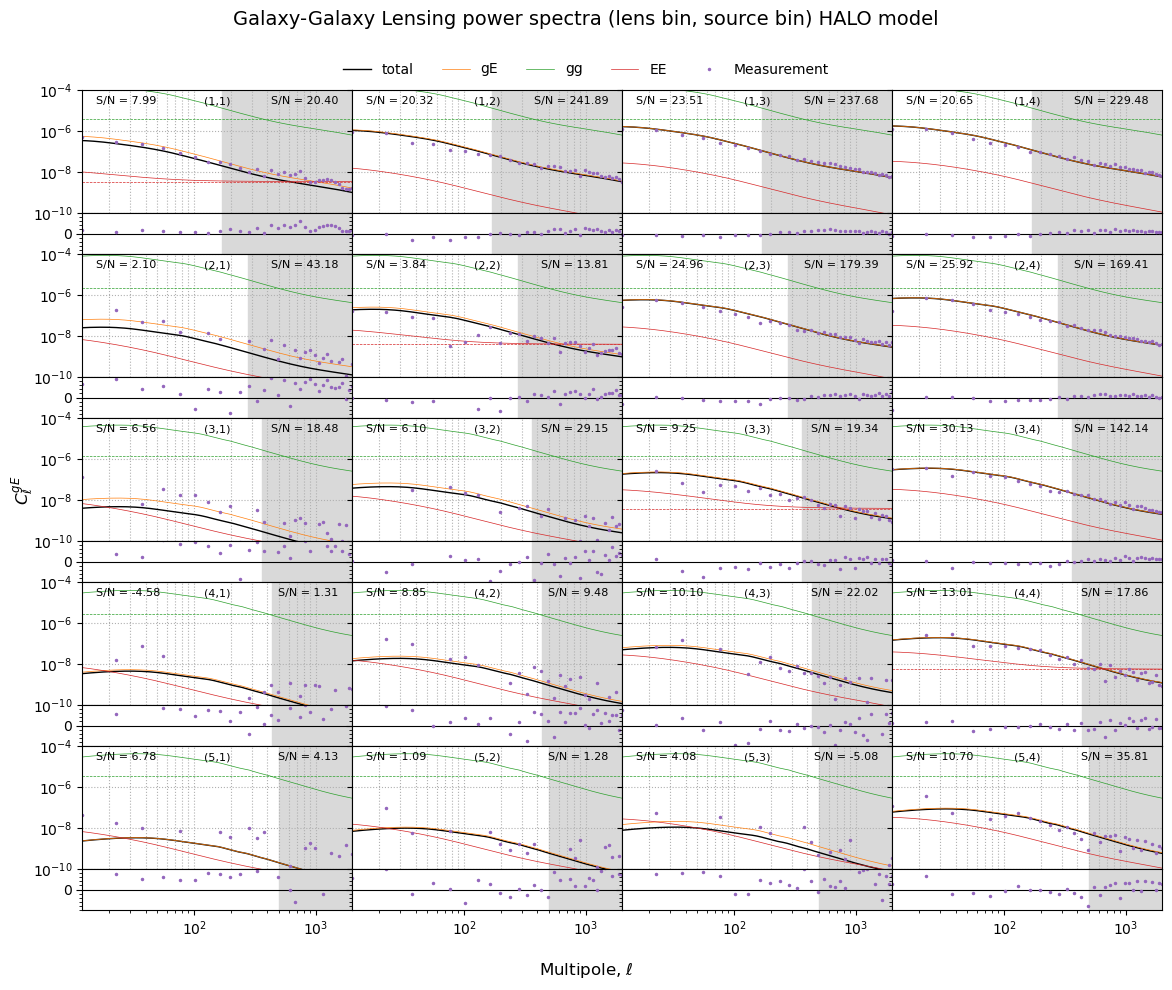

In [11]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

# Grid sizes
n_lens, n_source = 5, 4

ells = ells_data

# --- Create figure and GridSpec with smaller height ratio for residuals ---
fig = plt.figure(figsize=(12, 10))
fig.suptitle(f'Galaxy-Galaxy Lensing power spectra (lens bin, source bin) HALO model',    
    fontsize=14, y=0.98)

gs = GridSpec(n_lens * 2, n_source, figure=fig, 
              height_ratios=[3, 1]*n_lens,  # main:residual ratio 3:1
              hspace=0.0, wspace=0.0)       # no gaps

# --- Loop over bins ---
for i in range(n_lens):
    for j in range(n_source):
        ax_main = fig.add_subplot(gs[2*i, j])
        ax_resid = fig.add_subplot(gs[2*i + 1, j], sharex=ax_main)

        # --- Main spectra ---
        ax_main.plot(ells, cls_total[i, j, :], color='black', lw=1, label='total')
        ax_main.plot(ells, cls_ge[i, j, :], color='C1', label='gE',lw=0.5)
        ax_main.plot(ells, cls_gg[i, j, :], color='C2', label='gg',lw=0.5)
        ax_main.plot(ells, cls_ee[i, j, :], color='C3', label='EE',lw=0.5)
        ax_main.axhline(1.0 / ngal_lens_dict[i],linestyle='--', color='C2',lw=0.5)
        if i==j:
            ax_main.axhline(sige_source_dict[j]**2 / ngal_source_dict[j],linestyle='--', color='C3',lw=0.5)
        ax_main.plot(ells_binned, pcls[i, j, 0, :], '.', color='C4', ms=3, label='Measurement')

        ax_main.set_xscale('log')
        ax_main.set_yscale('log')
        ax_main.grid(True, which='both', ls=':')
        ax_main.label_outer()  


        # --- Residuals ---
        delta_cl = np.log10(np.abs(pcls[i,j,0,:])) - np.log10(np.abs(cls_total_binned[i,j,:]))
        ax_resid.axhline(0, color='k', lw=0.8)
        ax_resid.plot(ells_binned, delta_cl, '.', color='C4', ms=3)
        ax_resid.set_xscale('log')
        ax_resid.set_ylim(-1, 1)

        minor_ticks = np.linspace(-1, 1, 11)  # 10 intervals
        ax_resid.yaxis.set_minor_locator(FixedLocator(minor_ticks))

        ax_resid.yaxis.set_major_locator(FixedLocator([0]))
        
        ax_resid.tick_params(axis='y', which='minor', length=2)
        ax_resid.tick_params(axis='y', which='major', length=4)
        ax_resid.label_outer()
        

        # --- Ticks & labels control ---
        if j > 0:
            ax_main.set_yticklabels([])

        # Shared limits for main plots
        ax_main.set_xlim(min(ells_binned), max(ells_binned))

        ax_main.axvspan(lmax_list[i], max(ells_binned), color='0.85', zorder=0)
        ax_resid.axvspan(lmax_list[i], max(ells_binned), color='0.85', zorder=0)

        ax_main.set_ylim(1e-10, 1e-4)

        # text in plots
        snr = snr_dict[(i+1,j+1)]
        chi2 = chi2_dict[(i+1,j+1)]
        snr_cut = snr_cut_dict[(i+1,j+1)]
        chi2_cut = chi2_cut_dict[(i+1,j+1)]
        #ax_main.text(0.05, 0.95, f"S/N = {snr_cut:.2f}\n$\\chi^2$ = {chi2_cut:.2f}",
        #             transform=ax_main.transAxes,va = 'top',ha = 'left', fontsize=8)
        ax_main.text(0.05, 0.95, f"S/N = {snr_cut:.2f}",
                     transform=ax_main.transAxes,va = 'top',ha = 'left', fontsize=8)
        ax_main.text(0.50, 0.95, f"({i+1},{j+1})",
                     transform=ax_main.transAxes,va = 'top',ha = 'center', fontsize=8)
        #ax_main.text(0.95, 0.95, f"S/N = {snr:.2f}\n$\\chi^2$ = {chi2:.2f}",
        #             transform=ax_main.transAxes,va = 'top',ha = 'right', fontsize=8)
        ax_main.text(0.95, 0.95, f"S/N = {snr:.2f}",
                     transform=ax_main.transAxes,va = 'top',ha = 'right', fontsize=8)


# --- Shared labels ---
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

handles, labels = ax_main.get_legend_handles_labels()

fig.legend(
    handles, labels,
    loc='upper center',
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.94)
)

plt.subplots_adjust(
    wspace=0.0, hspace=0.0,
    top=0.90,  
    bottom=0.08,
    left=0.08,
    right=0.98
)

plt.show()